In [ ]:
!pip install numpy
!pip install matplotlib
!pip install nltk

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.wsd import lesk


In [14]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/grayrest/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/grayrest/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/grayrest/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/grayrest/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/grayrest/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/grayrest/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
class AdvancedSentiAnalyzer:
    def __init__(self):
        # Добавляем лемматизатор
        self.lemmatizer = WordNetLemmatizer()
        # Создаем список негативных слов
        self.negations = {'not', 'no', 'never', 'none', 'nobody', 'nothing'}
        # Создаем список слов-усилителей
        self.intensifiers = {
            'very': 1.5,
            'extremely': 2.0,
            'highly': 1.7,
            'really': 1.3,
            'somewhat': 0.7,
            'slightly': 0.5,
            'too': 1.4,
            'absolutely': 1.8
        }

    def get_wordnet_pos(self, treebank_tag):
        """Определяет части речи слов"""
        
        if treebank_tag.startswith('J'):
            return wn.ADJ
        elif treebank_tag.startswith('V'):
            return wn.VERB
        elif treebank_tag.startswith('N'):
            return wn.NOUN
        elif treebank_tag.startswith('R'):
            return wn.ADV
        return None

    def get_contextual_synset(self, word, sentence, pos):
        """Выбирает значение слова с учетом контекста"""
        
        context_synset = lesk(word_tokenize(sentence.lower()), word, pos=pos)
        return context_synset or wn.synsets(word, pos=pos)[0] if wn.synsets(word, pos=pos) else None

    def analyze_sentence(self, sentence):
        """Вычисляет значения score для каждого слова в предложении"""
        
        tokens = word_tokenize(sentence)
        pos_tags = nltk.pos_tag(tokens)
        
        sentiment_scores = []
        negation_active = False
        intensifier_power = 1.0
        
        i = 0
        while i < len(pos_tags):
            word, pos_tag = pos_tags[i]
            wn_pos = self.get_wordnet_pos(pos_tag)
            
            # Обработка сложных отрицаний
            if word.lower() in self.negations:
                if i+1 < len(pos_tags) and pos_tags[i+1][0].lower() in self.intensifiers:
                    negation_active = True
                    intensifier_power = self.intensifiers[pos_tags[i+1][0].lower()]
                    i += 2
                    continue
                else:
                    negation_active = True
                    i += 1
                    continue
            
            # Обработка усилителей отдельно
            if word.lower() in self.intensifiers and not negation_active:
                intensifier_power = self.intensifiers[word.lower()]
                i += 1
                continue
                
            if wn_pos in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                lemma = self.lemmatizer.lemmatize(word, pos=wn_pos)
                synset = self.get_contextual_synset(lemma, sentence, wn_pos)
                
                if synset:
                    swn_synset = swn.senti_synset(synset.name())
                    pos = swn_synset.pos_score()
                    neg = swn_synset.neg_score()
                    obj = swn_synset.obj_score()
                    
                    # Применяем усилитель
                    pos *= intensifier_power
                    neg *= intensifier_power
                    
                    # Нормализуем
                    total = pos + neg + obj
                    pos, neg, obj = pos/total, neg/total, obj/total
                    
                    # Инвертируем при отрицании
                    if negation_active:
                        pos, neg = neg, pos
                    
                    sentiment_scores.append({
                        'word': word,
                        'pos': pos_tag,
                        'lemma': lemma,
                        'positive': round(pos, 4),
                        'negative': round(neg, 4),
                        'objective': round(obj, 4),
                        'negated': negation_active,
                        'intensifier': intensifier_power if intensifier_power != 1.0 else None,
                        'synset': synset.name(),
                        'definition': synset.definition()
                    })
            
            # Сбрасываем флаги
            negation_active = False
            intensifier_power = 1.0
            i += 1
            
        return sentiment_scores

    def analyze_text(self, text):
        """Вычесляет score для текста"""

        sentences = sent_tokenize(text)
        # Результаты для каждого предложения
        results = []
        # Результаты для всего текста
        all_words = []
        
        for sentence in sentences:
            scores = self.analyze_sentence(sentence)
            if scores:
                sent_pos = sum(w['positive'] for w in scores) / len(scores)
                sent_neg = sum(w['negative'] for w in scores) / len(scores)
                sent_obj = sum(w['objective'] for w in scores) / len(scores)
                
                results.append({
                    'sentence': sentence,
                    'words': scores,
                    'sentence_score': {
                        'positive': round(sent_pos, 4),
                        'negative': round(sent_neg, 4),
                        'objective': round(sent_obj, 4)
                    }
                })
                # Объединяем значения scores для каждого слова
                all_words.extend(scores)
        
        if all_words:
            text_pos = sum(w['positive'] for w in all_words) / len(all_words)
            text_neg = sum(w['negative'] for w in all_words) / len(all_words)
            text_obj = sum(w['objective'] for w in all_words) / len(all_words)
            
            return {
                'sentences': results,
                'text_score': {
                    'positive': round(text_pos, 4),
                    'negative': round(text_neg, 4),
                    'objective': round(text_obj, 4)
                }
            }
        return None

Обработка текста и вывод результата

In [16]:
def SentiWordNet(text):
    """Выводит результат работы алгоритма"""
    
    analyzer = AdvancedSentiAnalyzer()

    print("Полный анализ текста:")
    results = analyzer.analyze_text(text)

    # Вывод текстовых результатов
    for i, sent in enumerate(results['sentences'], 1):
        print(f"\nПредложение {i}: {sent['sentence'].strip()}")
        print(f"\nОбщая оценка:")
        print(f"Позитивность: {sent['sentence_score']['positive']:.3f}")
        print(f"Негативность: {sent['sentence_score']['negative']:.3f}")
        print(f"Объективность: {sent['sentence_score']['objective']:.3f}")
        
        print("\nДетализация по словам:")
        for word in sent['words']:
            print(f"\n  Слово: {word['word']} ({word['pos']})")
            if word['negated']:
                print("  [ОТРИЦАНИЕ ПРИМЕНЕНО]")
            if word['intensifier']:
                print(f"  [УСИЛИТЕЛЬ x{word['intensifier']:.1f}]")
            print(f"  Лемма: {word['lemma']}")
            print(f"  Позитивность: {word['positive']:.3f}")
            print(f"  Негативность: {word['negative']:.3f}")
            print(f"  Объективность: {word['objective']:.3f}")
            print(f"  Определение: {word['definition']}")

    print("\nИтоговые оценки текста:")
    print(f"Позитивность: {results['text_score']['positive']:.3f}")
    print(f"Негативность: {results['text_score']['negative']:.3f}")
    print(f"Объективность: {results['text_score']['objective']:.3f}")

    sentences = [f"Предложение {i}" for i in range(1, len(results['sentences'])+1)]
    pos_scores = [s['sentence_score']['positive'] for s in results['sentences']]
    neg_scores = [s['sentence_score']['negative'] for s in results['sentences']]
    obj_scores = [s['sentence_score']['objective'] for s in results['sentences']]

    # График оценок по предложениям
    plt.figure(figsize=(12, 6))

    bar_width = 0.25
    index = np.arange(len(sentences))

    plt.barh(index, pos_scores, bar_width, label='Позитивность', color='green')
    plt.barh(index + bar_width, neg_scores, bar_width, label='Негативность', color='red')
    plt.barh(index + 2*bar_width, obj_scores, bar_width, label='Объективность', color='orange')

    plt.ylabel('Предложения')
    plt.xlabel('Оценка')
    plt.title('Эмоциональная окраска предложений')
    plt.yticks(index + bar_width, sentences)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Оценка для всего текста
    plt.figure(figsize=(8, 8))
    labels = ['Позитивность', 'Негативность', 'Объективность']
    sizes = [results['text_score']['positive'], 
                results['text_score']['negative'], 
                results['text_score']['objective']]
    colors = ['green', 'red', 'orange']
    explode = (0.1, 0, 0)  # Выделяем позитивность

    # Создаем горизонтальную диаграмму
    plt.barh(labels, sizes, color=colors, edgecolor='black')

    # Добавляем проценты на горизонтальную диаграмму
    for i in range(len(sizes)):
        plt.text(sizes[i], i, f'{sizes[i]} ({sizes[i] / sum(sizes) * 100:.1f}%)', va='center')

    plt.title('Общая эмоциональная окраска текста')
    plt.xlabel('Оценка')
    plt.ylabel('Категории')
    plt.tight_layout()
    plt.show()


In [ ]:
text = """
Python is much slower than more efficient languages like C and Java. Python is interpreted and dynamically-typed, 
so the run-time compiler has a lot of work to do. It must constantly validate the type of each variable. 
This means Python is not the best choice for scenarios where speed is critical.
"""
SentiWordNet(text)

Полный анализ текста:

Предложение 1: Isn't it just fantastic how every small inconvenience feels like the end of the world?

Общая оценка:
Позитивность: 0.109
Негативность: 0.156
Объективность: 0.734

Детализация по словам:

  Слово: Is (VBZ)
  Лемма: Is
  Позитивность: 0.250
  Негативность: 0.125
  Объективность: 0.625
  Определение: have the quality of being; (copula, used with an adjective or a predicate noun)

  Слово: just (RB)
  Лемма: just
  Позитивность: 0.125
  Негативность: 0.000
  Объективность: 0.875
  Определение: exactly at this moment or the moment described

  Слово: fantastic (JJ)
  Лемма: fantastic
  Позитивность: 0.375
  Негативность: 0.000
  Объективность: 0.625
  Определение: ludicrously odd

  Слово: small (JJ)
  Лемма: small
  Позитивность: 0.000
  Негативность: 0.375
  Объективность: 0.625
  Определение: limited or below average in number or quantity or magnitude or extent

  Слово: inconvenience (NN)
  Лемма: inconvenience
  Позитивность: 0.125
  Негативность:

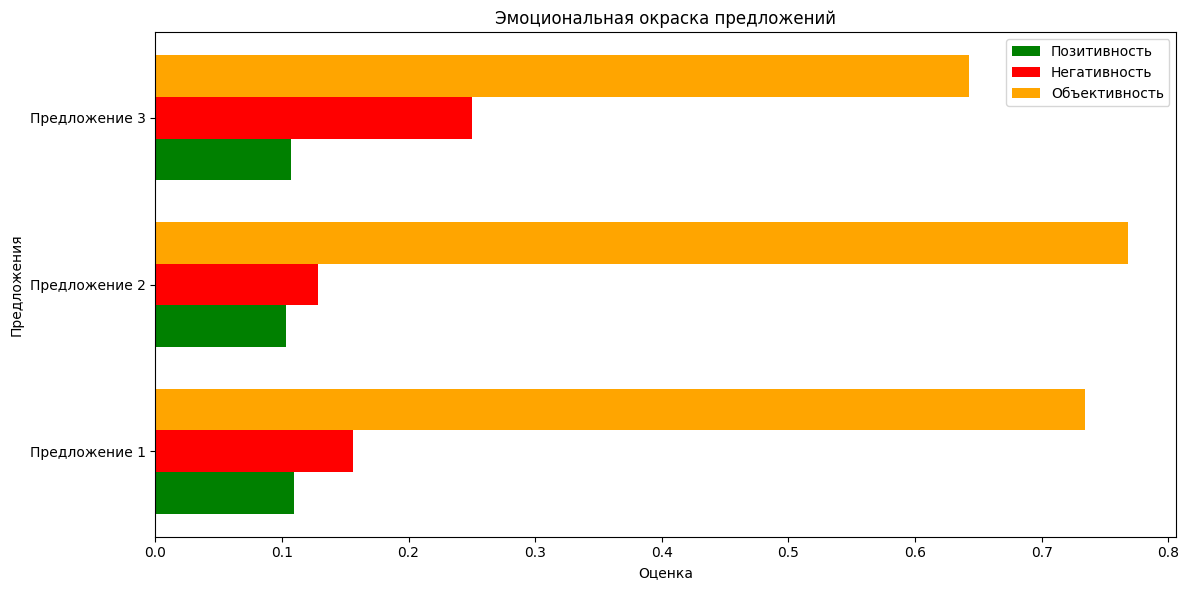

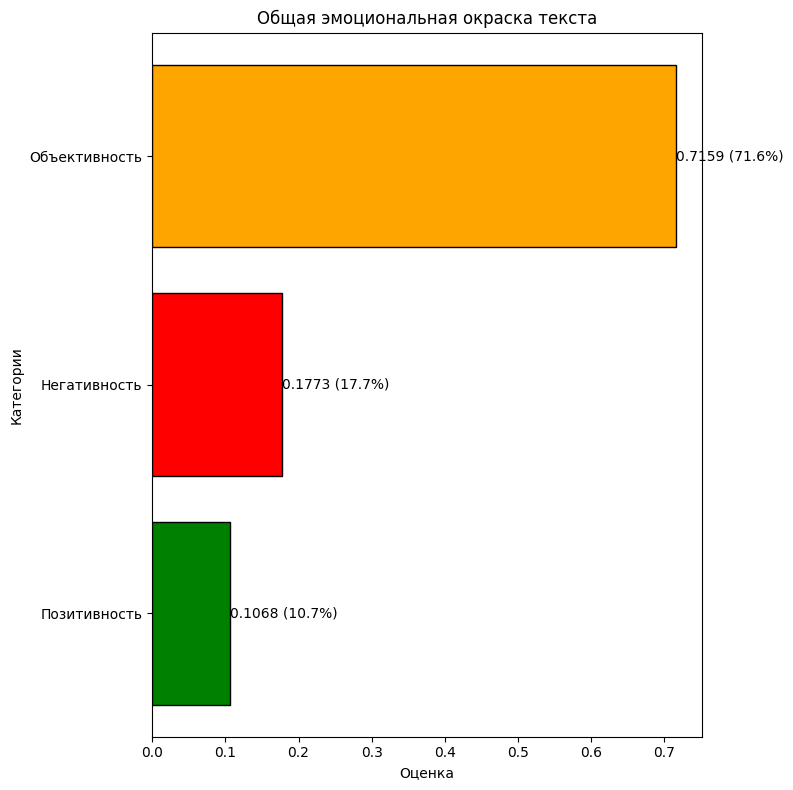

In [18]:
text = """
Isn't it just fantastic how every small inconvenience feels like the end of the world? 
I absolutely adore when my coffee gets cold while I’m scrolling through my endless to-do list. 
It really adds that extra touch of excitement to my otherwise thrilling day!
"""
SentiWordNet(text)